In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


# The Keras functional API

Funcional API ayuda a dar más felixibilidad a los modelos,permitiendoles tener multiples salidas y entradas, para definir modelos multitarea o al definir variables condicionadas, para manejar topologias de modelos no lineales.
Permite definir las capas del modelo como funciones, lo unico que cambia es la definicion del modelo, la compilacion, entrenamiento y evaluacion pueden implementarse de la misma forma.

In [ ]:
#podemos tener modelo con multiples entradas y multiples salidas
model=Model(inputs=[entrada1,...,entradan],outputs=[salida1,...,salidam])

#ahora hay que tener mas cuidado a la hora de compilar el modelo pues cada salida puede tener su propia funcion de perdida
#debemos pasar la lista de funciones de perdida en el mismo orden de la salida a la que pertenecen
#si tenemos distintas funciones perdida, debemos tener una forma de combinarlas en una sola que sea la que se optimice para el
#entrenamiento del modelo para esto se define loss_weights es una lista de pesos (flotantes 1 por funcion de perdida)
#que forma la funcion perdida final como una combinacion linela peso1*loss1+...+pesom*lossm y esta es la funcion de perdida a optimizar 
model.compile(loss=['loss1',...,'lossm'],loss_weights=[peso1,...,pesom],metrics=['accuracy','rms'])

#a la hora de entrenar tambien debemos pasar las entradas y salidas correspondientes
model.fit([x_1,...,x_n],[y_1,...,y_m],validation_split=0.2,epochs=20)

#puedes definir el entrenamiento y la compilacion en forma de diccionario (llave:valor) donde la llave
#es el nombre de la capa que debemos definir en el parametro name=
model.compile(loss={'salida1':'loss1',...,'salidam':'lossm'},loss_weights={'salida1':peso1,...,'salidam':pesom},
              metrics=['accuracy','rms'])
model.fit({'entrada1':x_1,...,'entradan':x_n},{'salida1':y_1,...,'salidam':y_m},validation_split=0.2,epochs=20)


 ## Coding tutorials
 #### [1. Multiple inputs and outputs](#coding_tutorial_1)
 #### [2. Tensors and Variables](#coding_tutorial_2)
 #### [3. Accessing model layers](#coding_tutorial_3)
 #### [4. Freezing layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Multiple inputs and outputs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the acute inflammations dataset

The `acute inflammations` was created by a medical expert as a data set to test the expert system, which will perform the presumptive diagnosis of two diseases of the urinary system. You can find out more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

Attribute information:

Inputs:
- Temperature of patient : 35C-42C
- Occurrence of nausea : yes/no
- Lumbar pain : yes/no
- Urine pushing (continuous need for urination) : yes/no
- Micturition pains : yes/no
- Burning of urethra, itch, swelling of urethra outlet : yes/no

Outputs:
- decision 1: Inflammation of urinary bladder : yes/no
- decision 2: Nephritis of renal pelvis origin : yes/no

#### Import the data

The dataset required for this tutorial can be downloaded from the following link:

https://drive.google.com/open?id=1CDPQSqpI7OjNIgOERWaI-BlQMI6vjzb9

You should store this file in Drive for use in this Colab notebook.

#### Load the data

In [3]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the dataset

from sklearn.model_selection import train_test_split

pd_dat = pd.read_csv('/content/diagnosis.csv')
dataset = pd_dat.values

In [5]:
# Build train and test data splits

X_train, X_test, Y_train, Y_test = train_test_split(dataset[:,:6], dataset[:,6:], test_size=0.33)

In [6]:
# Assign training and testing inputs/outputs

temp_train, nocc_train, lumbp_train, up_train, mict_train, bis_train = np.transpose(X_train)
temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test = np.transpose(X_test)

inflam_train, nephr_train = Y_train[:, 0], Y_train[:, 1]
inflam_test, nephr_test = Y_test[:, 0], Y_test[:, 1]

#### Build the model

In [9]:
# Build the input layers

#importemos capas que utilizaremos
from tensorflow.keras import Input, layers

#definamos todas las entradas 1 pos sintoma
shape_inputs=(1,)
temperature=Input(shape=shape_inputs,name='temp')
nausea_occurence=Input(shape=shape_inputs,name='nocc')
lumbar_pain=Input(shape=shape_inputs,name='lumbp')
urine_pushing=Input(shape=shape_inputs,name='up')
micturition_pains=Input(shape=shape_inputs,name='mict')
bis=Input(shape=shape_inputs,name='bis')

In [10]:
# Create a list of all the inputs

list_inputs = [temperature, nausea_occurence, lumbar_pain, urine_pushing, 
               micturition_pains, bis]

In [12]:
# Merge all input features into a single large vector
x=layers.concatenate(list_inputs)

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'concatenate_1')>

In [14]:
# Use a logistic regression classifier for disease prediction

inflammation_pred=layers.Dense(1,activation='sigmoid',name='inflam')(x)
nephritis_pred=layers.Dense(1,activation='sigmoid',name='nephr')(x)

In [15]:
# Create a list of all the outputs

list_outputs = [inflammation_pred, nephritis_pred]

In [18]:
# Create the model object
model=tf.keras.Model(inputs=list_inputs,outputs=list_outputs)

#### Plot the model

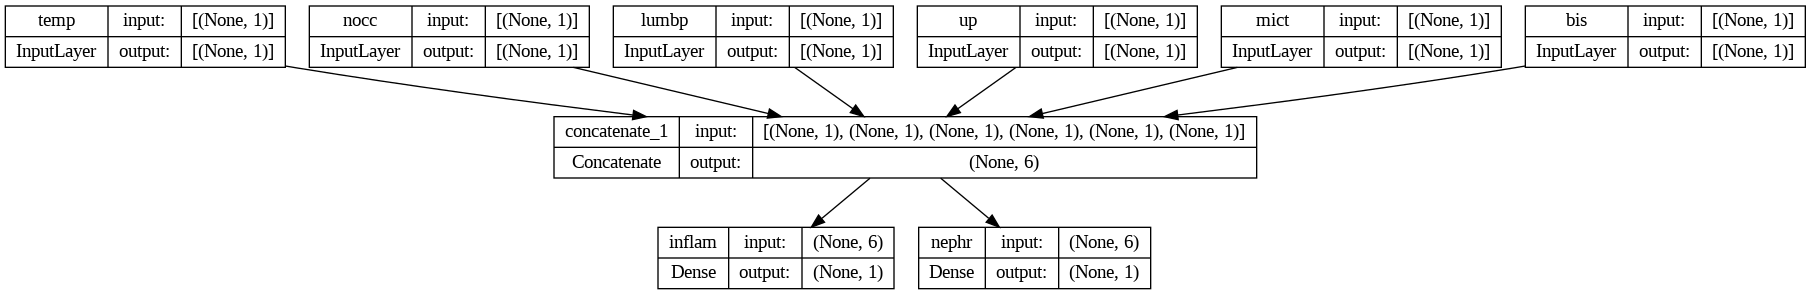

In [19]:
# Display the multiple input/output model
#pasamos modelo, ruta para guardar png , si queremos ver info de formas
tf.keras.utils.plot_model(model,'multisalidaentrada.png',show_shapes=True)

#### Compile the model

In [20]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3),
              loss={'inflam':'binary_crossentropy',
                    'nephr':'binary_crossentropy'},
              metrics=['acc'],
              loss_weights=[1.,0.2])

#### Fit the model 

In [21]:
# Define training inputs and outputs

inputs_train = {'temp': temp_train, 'nocc': nocc_train, 'lumbp': lumbp_train,
                'up': up_train, 'mict': mict_train, 'bis': bis_train}

outputs_train = {'inflam': inflam_train, 'nephr': nephr_train}

In [23]:
# Train the model
history=model.fit(inputs_train,outputs_train,epochs=1000,batch_size=128,verbose=0)

#### Plot the learning curves

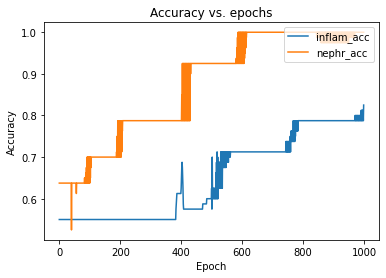

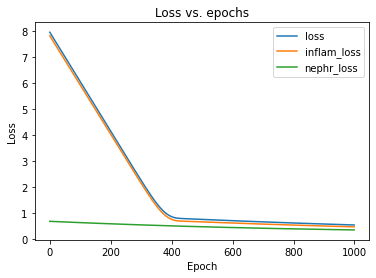

In [24]:
# Plot the training accuracy

acc_keys = [k for k in history.history.keys() if k in ('inflam_acc', 'nephr_acc')] 
loss_keys = [k for k in history.history.keys() if not k in acc_keys]

for k, v in history.history.items():
    if k in acc_keys:
        plt.figure(1)
        plt.plot(v)
    else:
        plt.figure(2)
        plt.plot(v)

plt.figure(1)
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(acc_keys, loc='upper right')

plt.figure(2)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loss_keys, loc='upper right')

plt.show()

In [25]:
# Evaluate the model
model.evaluate([temp_test,nocc_test,lumbp_test,up_test,mict_test,bis_test],
               [inflam_test,nephr_test],verbose=2)

2/2 - 0s - loss: 0.4858 - inflam_loss: 0.4096 - nephr_loss: 0.3808 - inflam_acc: 0.9250 - nephr_acc: 1.0000 - 442ms/epoch - 221ms/step


[0.48581188917160034,
 0.4096427857875824,
 0.38084572553634644,
 0.925000011920929,
 1.0]

***
<a id="coding_tutorial_2"></a>
## Tensors and Variables

In [26]:
import numpy as np

#### Create Variable objects

In [27]:
# Create Variable objects of different type with tf.Variable

strings = tf.Variable(["Hello world!"], tf.string)
floats  = tf.Variable([3.14159, 2.71828], tf.float64)
ints = tf.Variable([1, 2, 3], tf.int32)
complexs = tf.Variable([25.9 - 7.39j, 1.23 - 4.91j], tf.complex128)

In [28]:
# Initialise a Variable value
tf.Variable(tf.constant(4.2,shape=(3,3)))

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2]], dtype=float32)>

#### Use and modify Variable values

In [30]:
# Use the value of a Variable

v = tf.Variable(0.0)
w = v + 1  # w is a tf.Tensor which is computed based on the value of v.

print(type(w))
w

<class 'tensorflow.python.framework.ops.EagerTensor'>


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [31]:
# Increment the value of a Variable
v.assign_add(1)
v

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>

In [32]:
# Decrement the value of a Variable
v.assign_sub(1)
v

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>

#### Create Tensor objects

Create a constant tensor and print its type as well as its shape:

In [33]:
# Create a constant Tensor

x = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(x)
print("dtype:", x.dtype)
print("shape:", x.shape)

tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)
dtype: <dtype: 'int32'>
shape: (3, 3)


In [34]:
# Obtain the value as a numpy array
x.numpy()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]], dtype=int32)

In [35]:
# Create a Tensor of type float32
x=tf.constant([[1,2,3],[4,5,6],[7,8,9]],dtype=tf.float32)
x

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]], dtype=float32)>

In [37]:
# Create coefficients

coeffs = np.arange(16)
coeffs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [39]:
# Initialise shapes
shape1=[8,2]
shape2=[4,4]
shape3=[2,2,2,2]

In [40]:
# Create Tensors of different shape

a = tf.constant(coeffs, shape=shape1)
print("\n a:\n ", a)

b = tf.constant(coeffs, shape=shape2)
print("\n b:\n ", b)

c = tf.constant(coeffs, shape=shape3)
print("\n c:\n ", c)


 a:
  tf.Tensor(
[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]], shape=(8, 2), dtype=int64)

 b:
  tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]], shape=(4, 4), dtype=int64)

 c:
  tf.Tensor(
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]], shape=(2, 2, 2, 2), dtype=int64)


#### Useful Tensor operations

In [41]:
# Create a constant Tensor

t = tf.constant(np.arange(80), shape=[5,2,8])

In [42]:
# Get the rank of a Tensor
rank=tf.rank(t)

In [43]:
# Display the rank

print("rank: ", rank)

rank:  tf.Tensor(3, shape=(), dtype=int32)


In [44]:
# Reshape a Tensor

t2=tf.reshape(t,[8,10])

In [45]:
# Display the new shape

print("t2.shape: ", t2.shape)

t2.shape:  (8, 10)


In [46]:
# Create ones, zeros, identity and constant Tensors
ones=tf.ones(shape=(2,3))
zeros=tf.zeros(shape=(2,4))
eye=tf.eye(3)
tensor7=tf.constant(7.0,shape=[2,2])

In [47]:
# Display the created tensors

print("\n Ones:\n ", ones)
print("\n Zeros:\n ", zeros)
print("\n Identity:\n ", eye)
print("\n Tensor filled with 7: ", tensor7)


 Ones:
  tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)

 Zeros:
  tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(2, 4), dtype=float32)

 Identity:
  tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)

 Tensor filled with 7:  tf.Tensor(
[[7. 7.]
 [7. 7.]], shape=(2, 2), dtype=float32)


In [48]:
# Create a ones Tensor and a zeros Tensor

t1 = tf.ones(shape=(2, 2))
t2 = tf.zeros(shape=(2, 2))

In [49]:
# Concatentate two Tensors
concat0=tf.concat([t1,t2],0)
concat1=tf.concat([t1,t2],1)

In [50]:
# Display the concatenated tensors

print(concat0)
print(concat1)

tf.Tensor(
[[1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[1. 1. 0. 0.]
 [1. 1. 0. 0.]], shape=(2, 4), dtype=float32)


In [51]:
# Create a constant Tensor

t = tf.constant(np.arange(24), shape=(3, 2, 4))
print("\n t shape: ", t.shape)


 t shape:  (3, 2, 4)


In [54]:
# Expanding the rank of Tensors
t1=tf.expand_dims(t,0)
t2=tf.expand_dims(t,1)
t3=tf.expand_dims(t,3)

In [55]:
# Display the shapes after tf.expand_dims

print("\n After expanding dims:\n t1 shape: ", t1.shape, "\n t2 shape: ", t2.shape, "\n t3 shape: ", t3.shape)


 After expanding dims:
 t1 shape:  (1, 3, 2, 4) 
 t2 shape:  (3, 1, 2, 4) 
 t3 shape:  (3, 2, 4, 1)


In [58]:
# Squeezing redundant dimensions
t1=tf.squeeze(t1,0)
t2=tf.squeeze(t2,1)
t3=tf.squeeze(t3,3)

In [59]:
# Display the shapes after tf.squeeze

print("\n After squeezing:\n t1 shape: ", t1.shape, "\n t2 shape: ", t2.shape, "\n t3 shape: ", t3.shape)


 After squeezing:
 t1 shape:  (3, 2, 4) 
 t2 shape:  (3, 2, 4) 
 t3 shape:  (3, 2, 4)


In [60]:
# Slicing a Tensor
x=tf.constant([1,2,3,4,5,6,7,8,9])
x[1:4]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 3, 4], dtype=int32)>

#### Doing maths with Tensors

In [61]:
# Create two constant Tensors

c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])

In [62]:
# Matrix multiplication
matmul_cd=tf.matmul(c,d)

In [63]:
# Display the result

print("\n tf.matmul(c,d):\n", matmul_cd)


 tf.matmul(c,d):
 tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [66]:
# Elementwise operations
c_times_d=c*d
c_plus_d=c+d
c_minus_d=c-d
c_div_c=c/c

In [67]:
# Display the results

print("\n c*d:\n", c_times_d)
print("\n c+d:\n", c_plus_d)
print("\n c-d:\n", c_minus_d)
print("\n c/c:\n", c_div_c)


 c*d:
 tf.Tensor(
[[1. 2.]
 [0. 4.]], shape=(2, 2), dtype=float32)

 c+d:
 tf.Tensor(
[[2. 3.]
 [3. 5.]], shape=(2, 2), dtype=float32)

 c-d:
 tf.Tensor(
[[0. 1.]
 [3. 3.]], shape=(2, 2), dtype=float32)

 c/c:
 tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


In [68]:
# Create Tensors

a = tf.constant([[2, 3], [3, 3]])
b = tf.constant([[8, 7], [2, 3]])
x = tf.constant([[-6.89 + 1.78j], [-2.54 + 2.15j]])

In [70]:
# Absolute value of a Tensor
absx=tf.abs(x)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[7.11621388],
       [3.32777704]])>

In [71]:
# Power of a Tensor
powab=tf.pow(a,b)

In [72]:
# Display the results

print("\n ", absx)
print("\n ", powab)


  tf.Tensor(
[[7.11621388]
 [3.32777704]], shape=(2, 1), dtype=float64)

  tf.Tensor(
[[ 256 2187]
 [   9   27]], shape=(2, 2), dtype=int32)


#### Randomly sampled constant tensors

In [73]:
# Create a Tensor with samples from a Normal distribution
tn=tf.random.normal(shape=(2,2),mean=0,stddev=1.)

In [74]:
# Create a Tensor with samples from a Uniform distribution
tu=tf.random.uniform(shape=(2,1),minval=0,maxval=10,dtype='int32')

In [75]:
# Create a Tensor with samples from a Poisson distribution
tp=tf.random.poisson((2,2),5)

In [76]:
# More maths operations

d = tf.square(tn)
e = tf.exp(d)
f = tf.cos(c)

***
<a id="coding_tutorial_3"></a>
## Accessing model layers

Podemos acceder a distintas capas del modelo para analisar las entradas y salidas en ciertas capas intermedias del modelo, de esta forma podemos ver por ejemplo que caracteristicas esta abstayendo una red convolucional

In [ ]:
#podemos acceder a la lista de capas de un modelo mediante
model.layers

#podemos acceder a la capa i de la lista
capa_i=model.layers[i]

#podemos acceder a los pesos de la capa (te da pesos y sesgos)
pesos_capa_i=model.layers[i].weights

#si queremos pesos y sesgos como numpy array
pesos_capa_i=model.layers[i].get_weights()

#si queremos solo sesgos 
sesgos_capa_i=model.layers[i].bias

#si la capa es convolucional podemos acceder al kernel
kernel_capa_i=model.layers[i].kernel

#si la capa la denotamos con parametro name='nombre' podmeos acceder a las capas por
capa=model.get_layer('nombre')

#podemos acceder a sus demas elementos 
sesgo=model.get_layer('nombre').bias

In [ ]:
#podemos acceder a los tensores de entrada y salida de un modelo
entrada_capa=model.get_layer('nombre').input
salida_capa=model.get_layer('nombre').output

#podemos ocupar salidas y entradas de modelo para construir nuevos modelos
#podemos construir modelos apartir de otros quitandoles capas
modelo_nuevo=Model(inputs=modelo_viejo.input,outputs=lista_salidas_nuevas)

#podemos generar nuevos modelos agregando capas 
modelo_nuevo=Sequential([
    modelo_viejo,#solo es nombre de modelo no hay que definirlo todo
    Dense('parametros de capa densa')#agregamos una capa nueva
])

#tambien podemos agregar capas al inal con funcional agregandolas como nuevas salidas

In [77]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the pre-trained model

In this section, we aim to demonstrate accessing layer attributes within a model.

Let's get started by loading the `VGG19` pre-trained model from the `keras.applications` library, which is a very deep network trained on more than a million images from the ImageNet database. The network is trained to classify images into 1000 object categories.

In [82]:
# Load the VGG19 model

#cargamos vgg16 preentrenada
from keras.applications.vgg19 import VGG19
vgg_model=VGG19()

574710816/574710816 [==============================] - 5s 0us/step


In [83]:
# Get the inputs, layers and display the summary

#obtenemos entradas , capas y el resumen
vgg_input = vgg_model.input
vgg_layers = vgg_model.layers
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

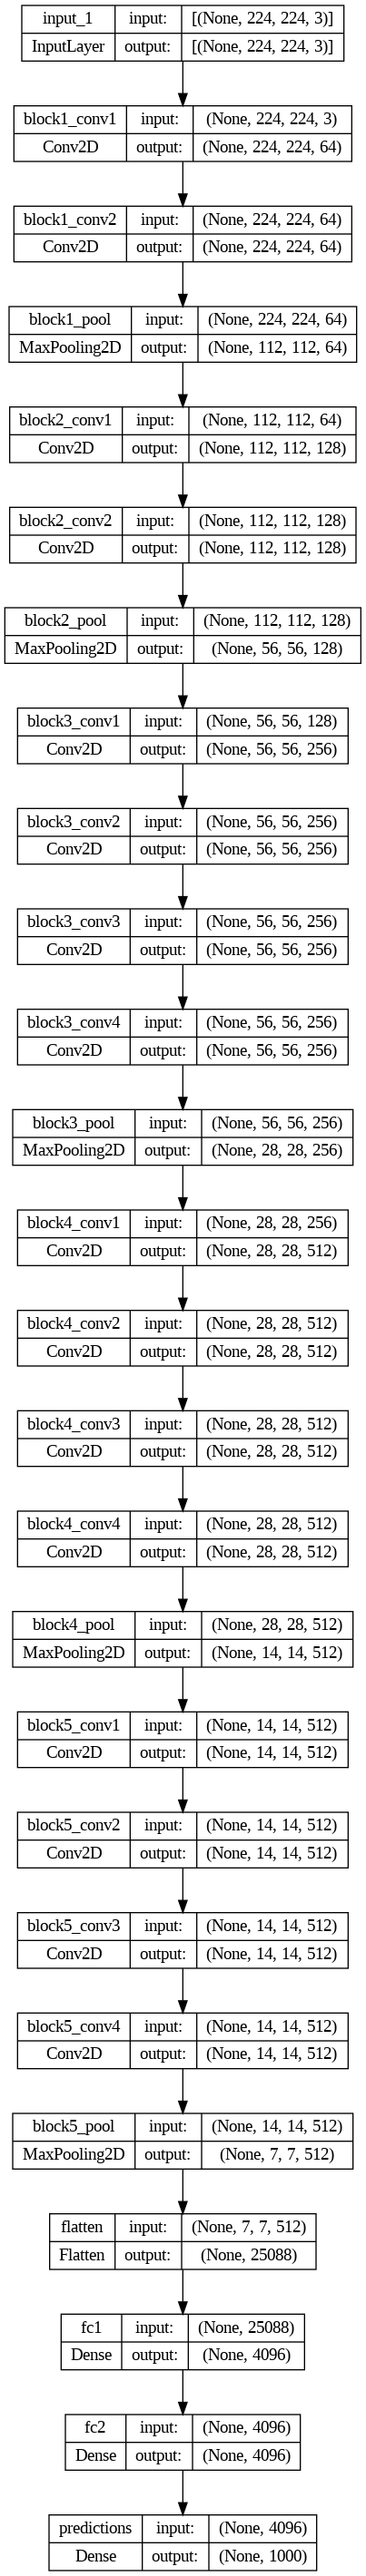

In [87]:
#graficamos el modelo
tf.keras.utils.plot_model(vgg_model,'original.png',show_shapes=True)

#### Build a model to access the layer outputs

In [84]:
from tensorflow.keras.models import Model

In [86]:
# Build a model that returns the layer outputs

#formamos lista de salidas de cada caoa
layer_outputs=[layer.output for layer in vgg_layers]

#creamos nuevo modelo con mismas entradas de vgg y salidas la lista anterior
features=Model(inputs=vgg_input,outputs=layer_outputs)

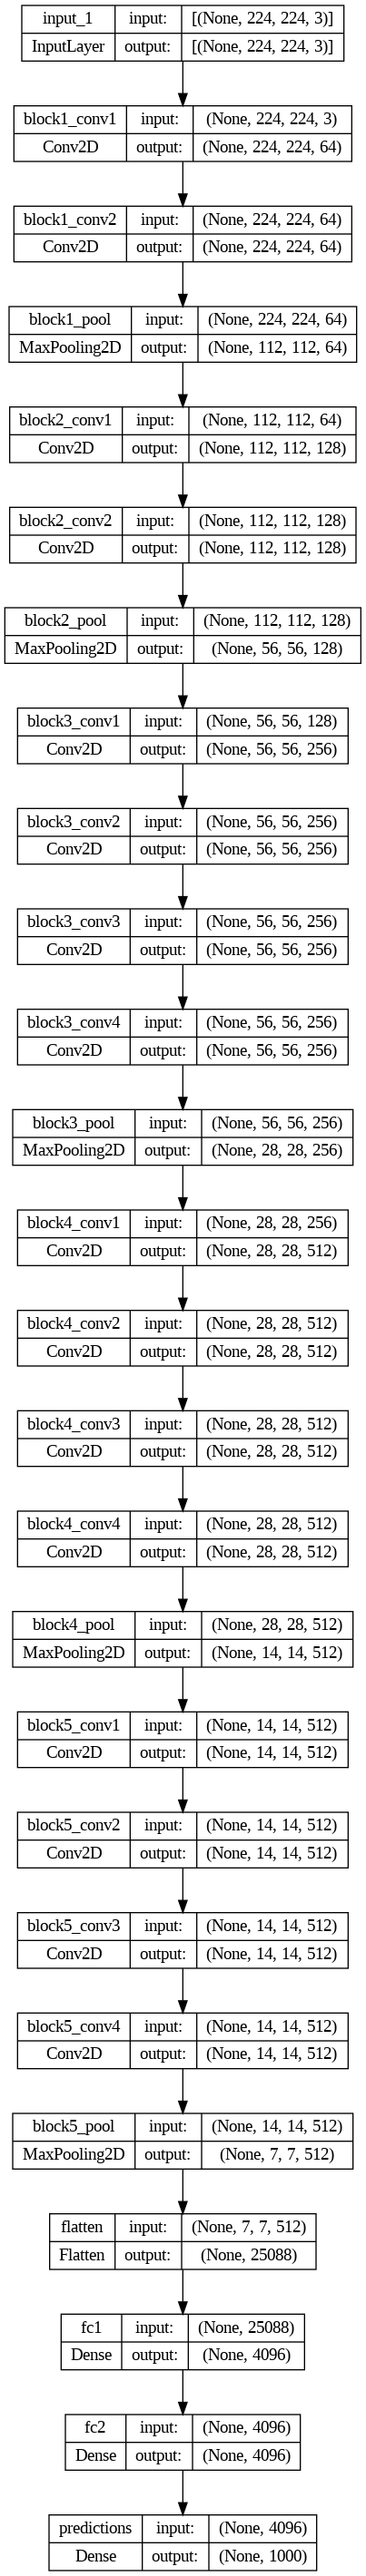

In [88]:
# Plot the model
#visualizamos modelo
tf.keras.utils.plot_model(features,'vgg19_model.png',show_shapes=True)

In [91]:
# Test the model on a random input
#probamos extrator en imagen random
img=np.random.random((1,224,224,3)).astype('float32')
extract_features=features(img)

In [92]:
extract_features

[<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
 array([[[[0.6353754 , 0.06850247, 0.923777  ],
          [0.5781725 , 0.26958737, 0.38654348],
          [0.82692933, 0.67048895, 0.7136574 ],
          ...,
          [0.6404582 , 0.44623205, 0.06125249],
          [0.9200174 , 0.20260602, 0.6155597 ],
          [0.55240905, 0.04268022, 0.8668665 ]],
 
         [[0.4567216 , 0.08948563, 0.867164  ],
          [0.7917497 , 0.78202546, 0.33637768],
          [0.9340601 , 0.5613985 , 0.43833488],
          ...,
          [0.11326564, 0.62728035, 0.10893191],
          [0.3267447 , 0.49794853, 0.4467561 ],
          [0.45028818, 0.55091375, 0.12189661]],
 
         [[0.67983353, 0.688426  , 0.5734972 ],
          [0.00268951, 0.9471567 , 0.7265467 ],
          [0.4593121 , 0.76417434, 0.62850654],
          ...,
          [0.30544764, 0.98674333, 0.80390275],
          [0.26645342, 0.07884796, 0.46470168],
          [0.730004  , 0.8511117 , 0.93298435]],
 
         ...,
 
       

#### Load the 'cool cat' picture

In Zambia’s South Luangwa National Park, a photographer had been watching a pride of lions while they slept off a feast from a buffalo kill. When this female walked away, he anticipated that she might be going for a drink and so he positioned his vehicle on the opposite side of the waterhole. The `cool cat` picture is one of the highly commended 2018 Image from Wildlife Photographer of the Year.

#### Import the picture

The dataset required for this tutorial can be downloaded from the following link:

https://drive.google.com/open?id=1myXpP8QFvhATqg0bPYhCpVS48_OgAC0L

You should store this file in Drive for use in this Colab notebook.

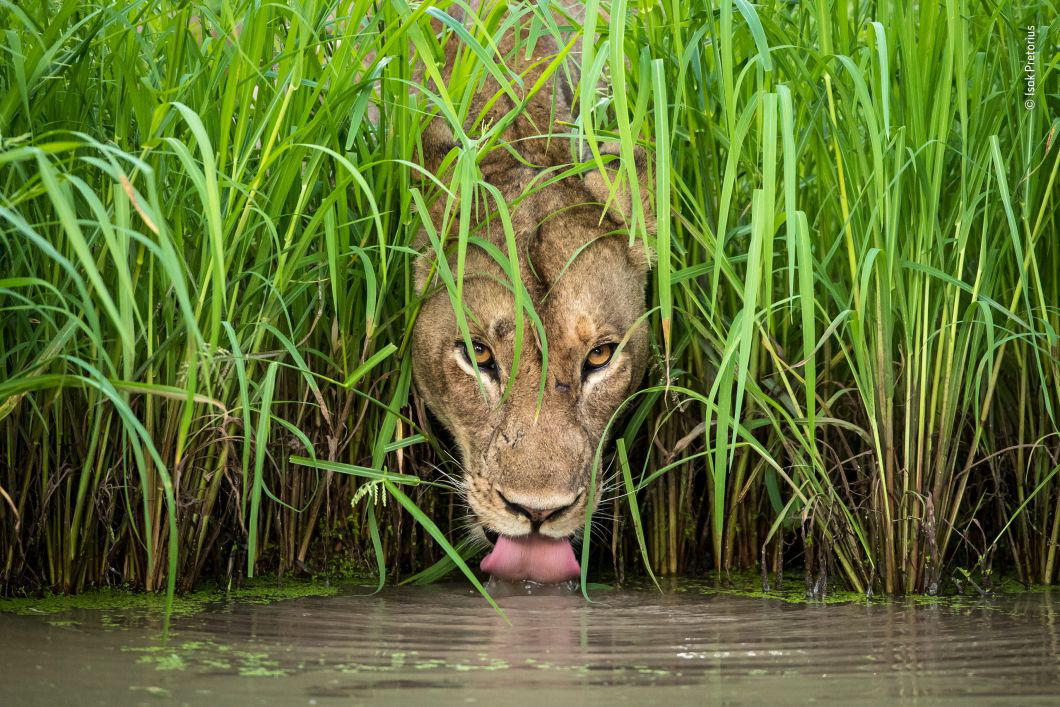

In [94]:
# Display the original image

#descargamos una imagen y la vemos
import IPython.display as display
from PIL import Image

display.display(Image.open('/content/cool_cat.jpg'))

#### Visualise network features from the input image

In [96]:
# Preprocess the image

#preprocesamos la imagen
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

img_path = '/content/cool_cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [97]:
# Extract the features

#extraemos su caracteristicas con el extractor
extracted_features=features(x)

(1, 224, 224, 3)


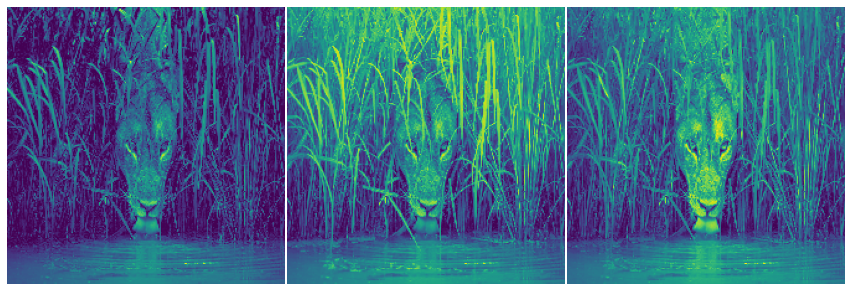

In [100]:
# Visualise the input channels

#visualicemos los canales de entrada
f1=extracted_features[0]
print(f1.shape)

imgs=f1[0,:,:]
plt.figure(figsize=(15,15))
for n in range(3):
  ax=plt.subplot(1,3,n+1)
  plt.imshow(imgs[:,:,n])
  plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)  

(1, 224, 224, 64)


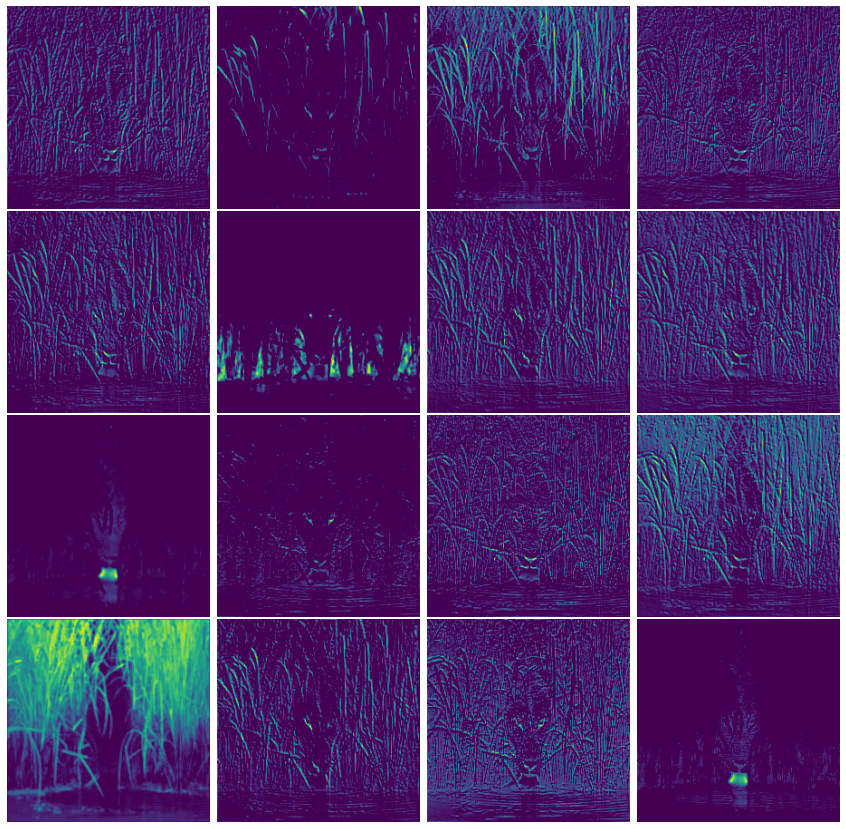

In [101]:
# Visualise some features in the first hidden layer

#veamos algunas caracteristicas abstaridas por la primera capa oculta
f2=extracted_features[1]
print(f2.shape)

imgs=f2[0,:,:]
plt.figure(figsize=(15,15))
for n in range(16):
  ax=plt.subplot(4,4,n+1)
  plt.imshow(imgs[:,:,n])
  plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)  

In [102]:
# Build a model to extract features by layer name

#creamos un modelo para extraer caracteristicas de capa por su nombre
extracted_features_block1_pool=Model(inputs=features.input,outputs=features.get_layer('block1_pool').output)
bloock1_pool_features=extracted_features_block1_pool.predict(x)

1/1 [==============================] - 0s 342ms/step


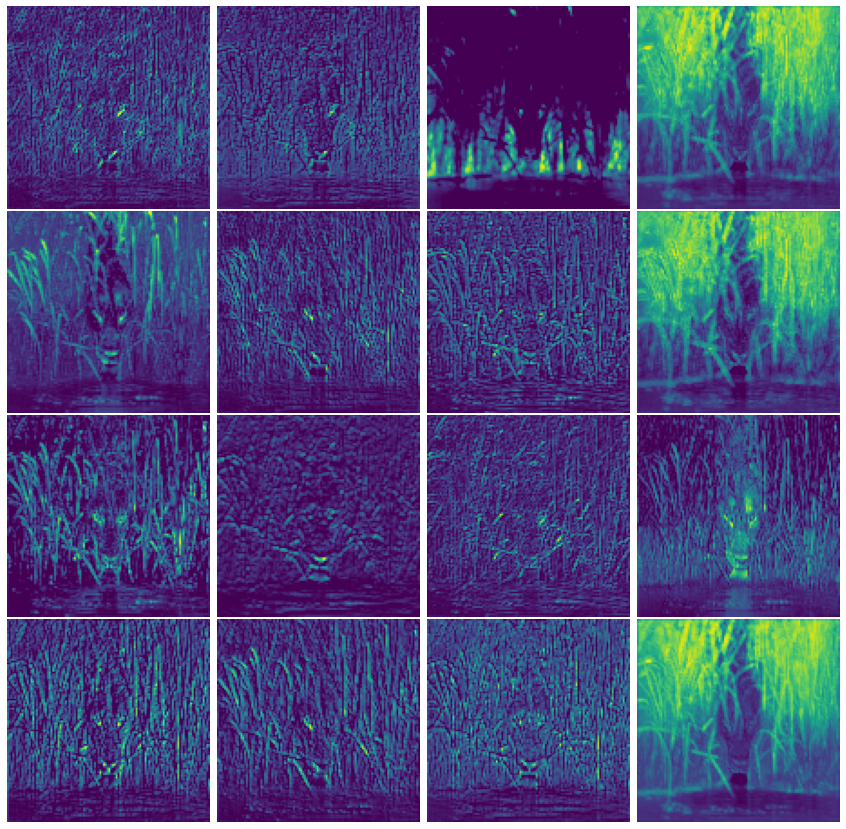

In [103]:
# Visualise some features from the extracted layer output
#visualizamos las caracteristicas que extrae
imgs=bloock1_pool_features[0,:,:]
plt.figure(figsize=(15,15))
for n in range(16):
  ax=plt.subplot(4,4,n+1)
  plt.imshow(imgs[:,:,n])
  plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)  


In [104]:
# Extract features from a layer deeper in the network
extracted_features_block5_conv4=Model(inputs=features.input,outputs=features.get_layer('block5_conv4').output)
bloock5_conv4_features=extracted_features_block5_conv4.predict(x)

1/1 [==============================] - 1s 1s/step


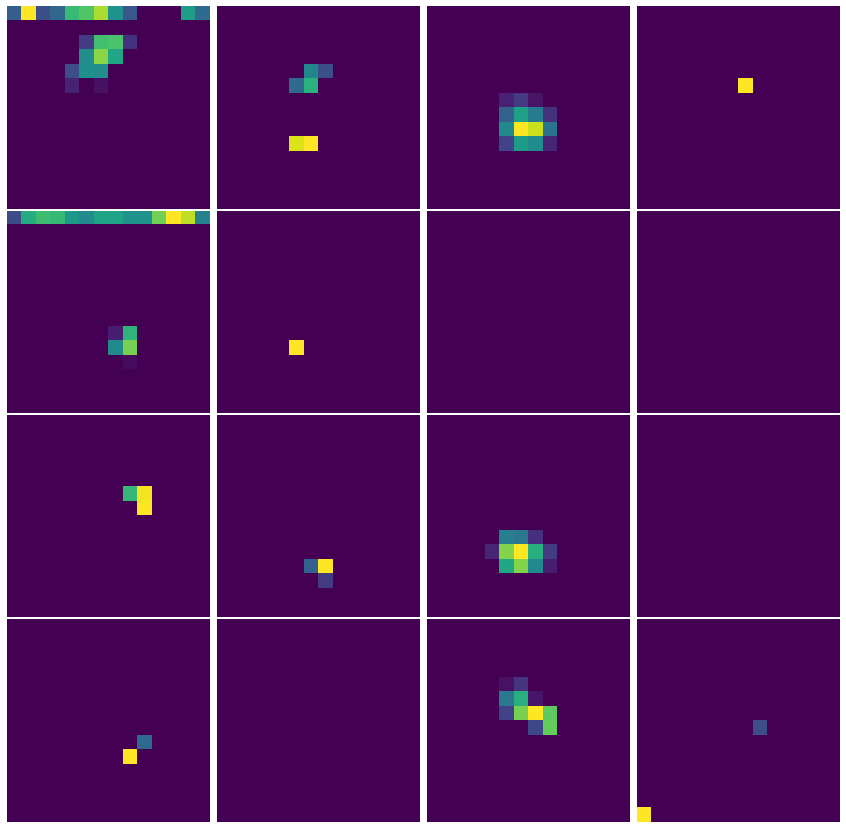

In [105]:
# Visualise some features from the extracted layer output
imgs=bloock5_conv4_features[0,:,:]
plt.figure(figsize=(15,15))
for n in range(16):
  ax=plt.subplot(4,4,n+1)
  plt.imshow(imgs[:,:,n])
  plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)  


***
<a id="coding_tutorial_4"></a>
## Freezing layers

Para hacer transferencia de conocimiento queremos que los pesos y sesgos de ciertas capas queden intactos al hacer el reentrenamoento esto lo logramos congelando las capas que queremos intactas durante el reentrenamiento.

In [ ]:
#para congelar una capa basta compasarle el parameto trainable=False
capa=Dense(8,trainable=False)

#tambien podemos hacerlo desde el modelo y con el prametro name='nombre' de la capa
modelo.get_layer('nombre').trainable=False

#podemos congelar el modelo completo
modelo.trainable=False

In [106]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Build the model

In [115]:
# Build a small Sequential model
#construimos modelo prototipo pequeño con todas sus variables entrenables
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    layers.Dense(4, input_shape=(4,), activation='relu', kernel_initializer='random_uniform',
                 bias_initializer='ones'),
    layers.Dense(2, activation='relu', kernel_initializer='lecun_normal', bias_initializer='ones'),
    layers.Dense(4, activation='softmax'),
])

In [116]:
# Display the model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


#### Examine the weight matrix variation over training

In [117]:
#funcion que extrae pesos del modelo
def get_weights(model):
  return[e.weights[0].numpy() for e in model.layers]

#funcion que extrae sesgis del modelo
def get_biases(model):
  return [e.bias.numpy() for e in model.layers]

#funcion que grafica diferencias entre pesos y sesgos
def plot_delta_weights(W0_layers,W1_layers,b0_layers,b1_layers):
  plt.figure(figsize=(8,8))
  for n in range(3):
      delta_l = W1_layers[n] - W0_layers[n]
      print('Layer '+str(n)+': bias variation: ', np.linalg.norm(b1_layers[n] - b0_layers[n]))
      ax = plt.subplot(1,3,n+1)
      plt.imshow(delta_l)
      plt.title('Layer '+str(n))
      plt.axis('off')
  plt.colorbar()
  plt.suptitle('Weight matrices variation');

In [118]:
# Retrieve the weights and biases
#extraemos los pesos del modelo antes de entrenar
W0_layers=get_weights(model)
b0_layers=get_biases(model)


In [119]:
# Construct a synthetic dataset

#generamos datos sinteticos
x_train = np.random.random((100, 4))
y_train = x_train

x_test = np.random.random((20, 4))
y_test = x_test

In [120]:
# Compile and fit the model

#compilamos el modelo
model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

#entrenamos el modelo
model.fit(x_train, y_train, epochs=50, verbose=False);

In [121]:
# Retrieve weights and biases

#extraemos los pesos despues de entrenan
W1_layers=get_weights(model)
b1_layers=get_biases(model)

Layer 0: bias variation:  0.23140268
Layer 1: bias variation:  0.122314356
Layer 2: bias variation:  0.31981698


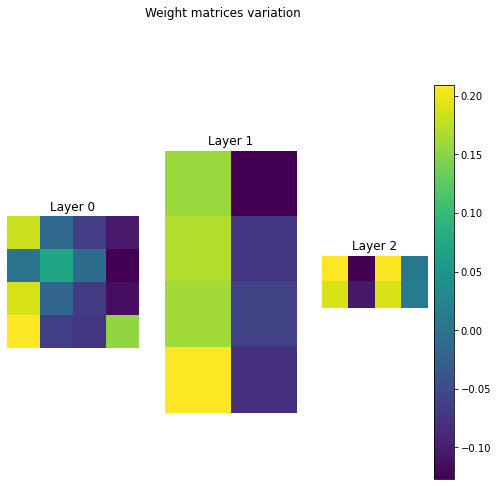

In [123]:
# Plot the variation

#graficamos y todos varian pue stodos cambian durante entrenamiento
plot_delta_weights(W0_layers,W1_layers,b0_layers,b1_layers)

#### Freeze layers at build time

In [124]:
# Count the trainable and non trainable variables before the freezing
n_trainable_variables=len(model.trainable_variables)
n_non_trainable_variables=len(model.non_trainable_variables)


In [125]:
# Display the number of trainable and non trainable variables before the freezing

print("\n Before freezing:\n\t Number of trainable variables: ", n_trainable_variables,
                         "\n\t Number of non trainable variables: ", n_non_trainable_variables)


 Before freezing:
	 Number of trainable variables:  6 
	 Number of non trainable variables:  0


In [126]:
# Build the model 
#ahora pones trainable=False en la primera capa
model = Sequential([
    layers.Dense(4, input_shape=(4,), activation='relu', kernel_initializer='random_uniform',
                 bias_initializer='ones',trainable=False),
    layers.Dense(2, activation='relu', kernel_initializer='lecun_normal', bias_initializer='ones'),
    layers.Dense(4, activation='softmax'),
])


In [127]:
# Count the trainable and non trainable variables after the freezing
n_trainable_variables=len(model.trainable_variables)
n_non_trainable_variables=len(model.non_trainable_variables)

In [128]:
# Display the number of trainable and non trainable variables after the freezing

print("\n After freezing:\n\t Number of trainable variables: ", n_trainable_variables,
                         "\n\t Number of non trainable variables: ", n_non_trainable_variables)


 After freezing:
	 Number of trainable variables:  4 
	 Number of non trainable variables:  2


In [129]:
# Retrieve weights and biases
#extraemos los pesos del modelo antes de netrenar
W0_layers=get_weights(model)
b0_layers=get_biases(model)

In [130]:
# Compile and fit the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

#entrenamos el modelo
model.fit(x_train, y_train, epochs=50, verbose=False);

In [131]:
# Retrieve weights and biases

#extraemos los pesos del modelo despues de entrenar
W1_layers=get_weights(model)
b1_layers=get_biases(model)

Layer 0: bias variation:  0.0
Layer 1: bias variation:  0.20204492
Layer 2: bias variation:  0.31186706


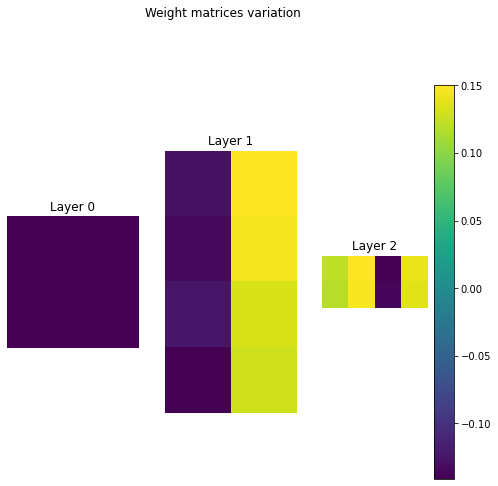

In [132]:
# Plot the variation

#la primera capa no varia con el entrenamiento pues no se entrena
plot_delta_weights(W0_layers,W1_layers,b0_layers,b1_layers)


#### Freeze layers of a pre-built model

In [133]:
# Count the trainable and non trainable variables before the freezing

print("\n Before freezing:\n\t Number of trainable variables: ", len(model.trainable_variables),
                         "\n\t Number of non trainable variables: ", len(model.non_trainable_variables))


 Before freezing:
	 Number of trainable variables:  4 
	 Number of non trainable variables:  2


In [134]:
# Freeze the second layer
model.layers[1].trainable=False

In [135]:
# Count the trainable and non trainable variables after the freezing

print("\n After freezing:\n\t Number of trainable variables: ", len(model.trainable_variables),
                        "\n\t Number of non trainable variables: ", len(model.non_trainable_variables))


 After freezing:
	 Number of trainable variables:  2 
	 Number of non trainable variables:  4


In [ ]:
# Compile and fit the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

model.fit(x_train, y_train, epochs=50, verbose=False);

In [136]:
# Retrieve weights and biases

W2_layers=get_weights(model)
b2_layers=get_biases(model)

Layer 0: bias variation:  0.0
Layer 1: bias variation:  0.0
Layer 2: bias variation:  0.0


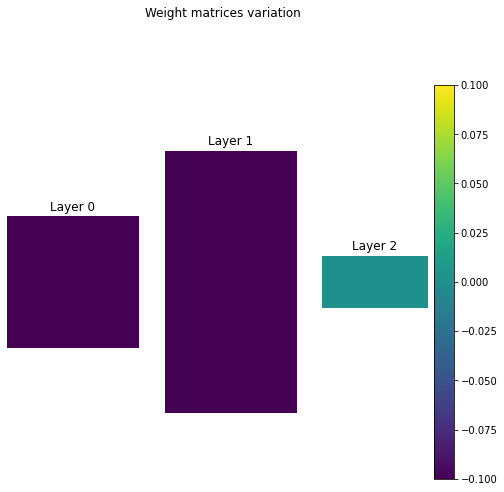

In [137]:
# Plot the variation
#la primera y la segunda capa no varian pues ninguna de las dos se entrena
plot_delta_weights(W1_layers,W2_layers,b1_layers,b2_layers)
